In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.optim import Adam
from torchvision.transforms import  Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop, Lambda
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics
from lightning.pytorch.loggers import WandbLogger
import wandb
import random
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
num_workers = 0

device = torch.device("cpu")

## Linux

In [3]:
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA-Version:", torch.version.cuda)
print("GPU-Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Keine GPU gefunden")

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 2


CUDA verfügbar: True
CUDA-Version: 12.4
GPU-Name: NVIDIA GeForce RTX 3070 Ti


## Load dataset

In [4]:
# Dataset Path
DATASET_PATHS = ["../Dataset/custom_local_data"]
DATASET_PATHS_TEST = ["../Dataset/test"]
PRICES_FILE_PATH = "../Dataset/prices.txt"
DATASET_PATHS_VALID = [] # Not used yet
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 64
SEED = 42

In [5]:
from lightning.pytorch import seed_everything

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
seed_everything(SEED)

Seed set to 42


42

## Load helper functions

In [6]:
import helper_functions as hp

## Data Info

In [7]:
num_clases = hp.get_num_clases(PRICES_FILE_PATH)
print(num_clases)


61


## create dataloader and Datasets

In [8]:

class ImagePriceDataset(Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.files = []
        for dataset_path in dataset_paths:
            if not os.path.exists(dataset_path):
                raise ValueError(f"Path {dataset_path} doesn't exist.")
            for f in os.listdir(dataset_path):
                if f.endswith(".jpg"):
                    self.files.append((f, dataset_path))
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name, dataset_path = self.files[idx]
        image, label = hp.load_image_labeles_classify(file_name, dataset_path, IMAGE_SIZE, num_clases)

        # Wenn das Bild im float32 Format vorliegt, skaliere es und wandle es in uint8 um
        if image.dtype == np.float32:
            image = (image * 255).astype(np.uint8)  # Skalieren auf [0, 255] und in uint8 umwandeln

        # Konvertiere das numpy-Array in ein PIL-Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)
    
# Transforms
transform = Compose([
    #Resize(IMAGE_SIZE),               # Skaliere die Bilder auf die gewünschte Größe
    Lambda(lambda x: hp.custom_augmentation(x)),
    RandomHorizontalFlip(p=0.5),       # Zufälliges horizontales Spiegeln mit 50% Wahrscheinlichkeit
    RandomRotation(degrees=180),        # Zufällige Rotation um bis zu ±15 Grad
    RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.0)),
    ColorJitter(brightness=0.03,        # Zufällige Anpassung der Helligkeit
                contrast=0.1,          # Kontrast
                saturation=0.1,        # Sättigung
                hue=0.03),              # Farbton
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

transform_test = Compose([
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

# Dataset
train_dataset = ImagePriceDataset(DATASET_PATHS, transform=transform)
test_dataset = ImagePriceDataset(DATASET_PATHS_TEST, transform_test)
# Train-Valid Split
if len(DATASET_PATHS_VALID) > 0:
    val_dataset = ImagePriceDataset(DATASET_PATHS_VALID, transform=transform)
else:    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


## test Augmentation

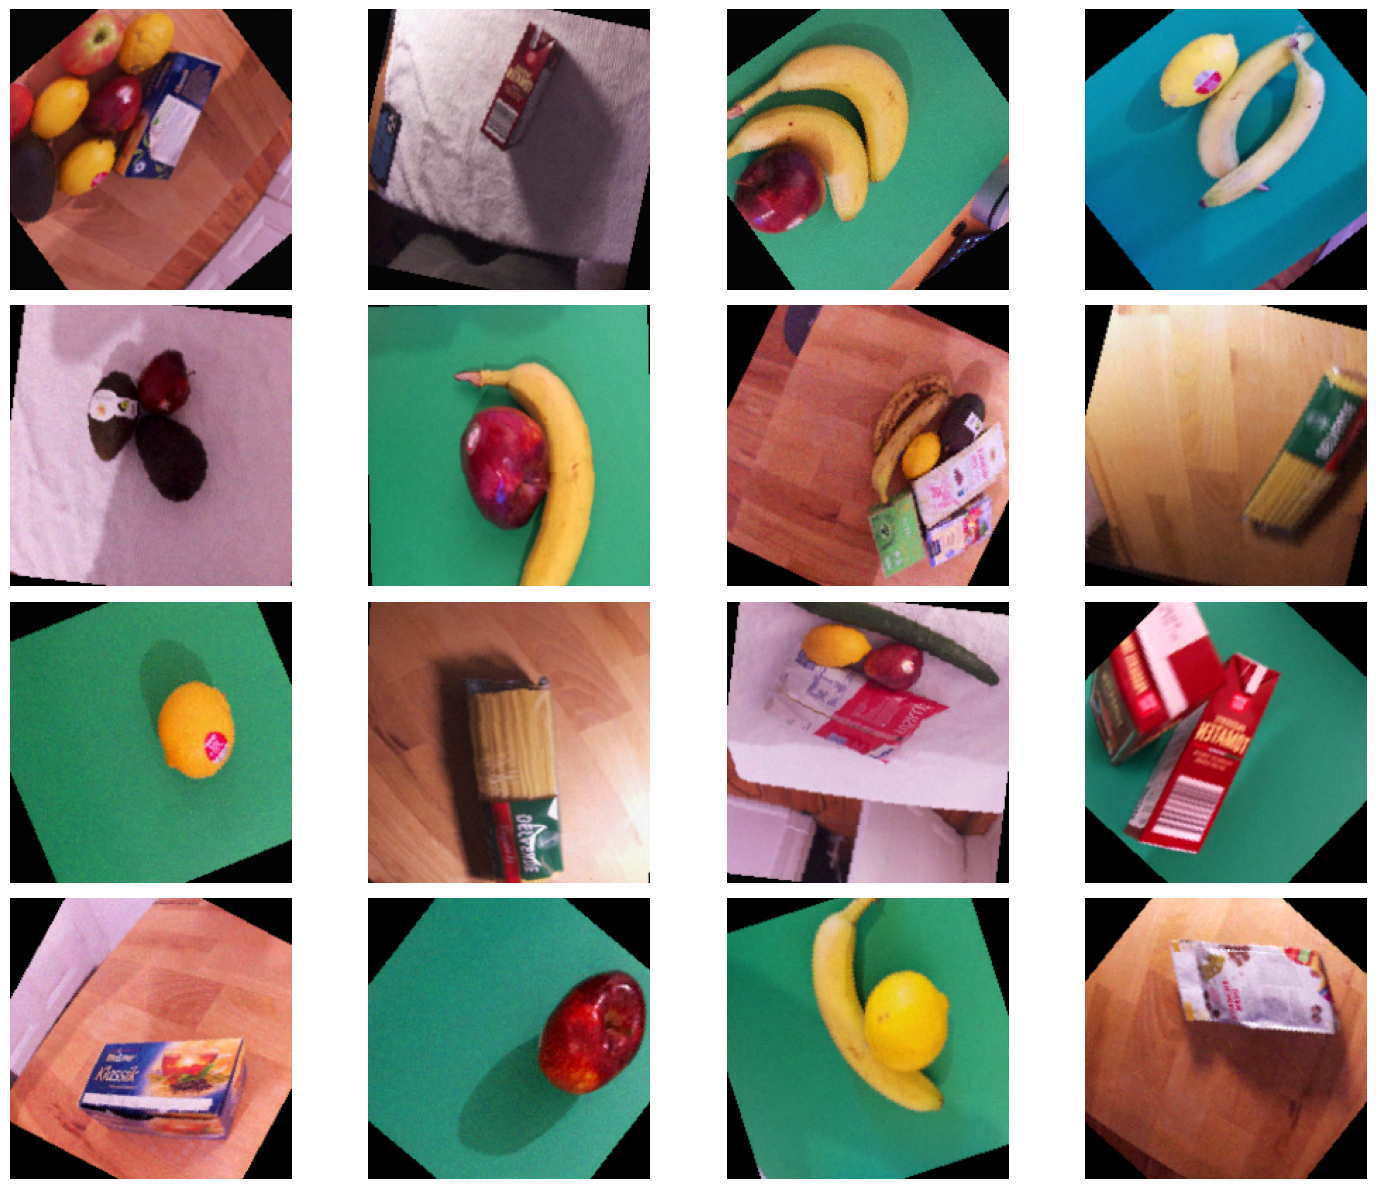

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Funktion zum Anzeigen von Bildern
def imshow(image, ax=None):
    # Wenn kein Ax angegeben wird, erstelle eine neue Achse
    if ax is None:
        fig, ax = plt.subplots()
        
    # Wandle den Tensor in ein NumPy-Array um und skaliere die Werte zurück auf [0, 1]
    image = image.permute(1, 2, 0).numpy()  # Von (C, H, W) nach (H, W, C)
    image = np.clip(image, 0, 1)  # Begrenze den Wertebereich auf [0, 1]
    
    ax.imshow(image)
    ax.axis('off')

# Hole ein Batch von Bildern aus dem DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Zeige die ersten 5 Bilder im Batch
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4 Zeilen, 5 Spalten
axes = axes.flatten()  # Flatten der 2D Achsenmatrix, um sie einfach zu durchlaufen

# Zeige die Bilder
for i in range(16):
    imshow(images[i], axes[i])  # Stelle jedes Bild in der jeweiligen Achse dar

# Zeige die Bilder
plt.tight_layout()  # Optimiert das Layout für bessere Übersicht
plt.show()


## classification Model

In [10]:
class RegressionModel(pl.LightningModule):
    def __init__(self, num_classes=num_clases, num_layers=6, num_filters=[32,32,32,32,32,32], pooling = [[1,2,3],[4]], kernel_size=3, learning_rate=1e-3):
        super().__init__()
        layers = []
        in_channels = 3  # Input-Kanäle, z. B. RGB-Bilder
        self.learning_rate = learning_rate
        self.optimizer = None
        
        # Convolutional Layers
        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, num_filters[i], kernel_size, padding="same", stride=1))
            layers.append(nn.ReLU())
            if i in pooling[0]: 
                layers.append(nn.MaxPool2d(kernel_size=2))
            elif i in pooling[1]:
                layers.append(nn.MaxPool2d(kernel_size=3))

            in_channels = num_filters[i]
        
        layers.append(nn.Flatten())
        # Die Ausgabe-Schicht nun für `num_classes` Klassen
        layers.append(nn.Linear(num_filters[len(num_filters)-1]*64, 512))  # Beispielhafte Größenanpassung
        layers.append(nn.ReLU())
        layers.append(nn.Linear(512, num_classes))  # Zahl der Klassen als Ausgangsgrößen
        
        self.model = nn.Sequential(*layers)
        
        self.criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss für Multi-Label-Klassifikation
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)  # Vorhersage für jede Klasse (Multilabel)
        
        # Verlustberechnung: Binary Cross-Entropy Loss
        loss = self.criterion(y_pred, y)  # y ist hier der Label-Vektor, der die Häufigkeit der Klassen darstellt
        
        # Logs
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        
        # Logs
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        
        self.log("test_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Erstelle einen Scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.965)
        # Alternativ: andere Scheduler wie CosineAnnealingLR, ReduceLROnPlateau, etc.
        
        return [self.optimizer], [scheduler]

In [21]:
import torch
import random
import matplotlib.pyplot as plt
import wandb

def show_predictions(model, test_dataset, num_samples=20, threshold=0.3):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    samples = random.sample(range(len(test_dataset)), num_samples)  # Wähle zufällig Samples aus

    for idx in samples:
        image, labels = test_dataset[idx]  # Lade das Bild und die Multi-Label Labels
        image_tensor = image.unsqueeze(0).to(model.device)  # Füge Batch-Dimension hinzu und verschiebe auf GPU/CPU

        # Vorhersage erzeugen
        with torch.no_grad():
            prediction = model(image_tensor).cpu().squeeze()  # Entferne die Batch-Dimension und bringe auf CPU

        # Erstelle ein Dictionary für Vorhersagen über dem Schwellenwert
        predicted_labels = {i: pred.item() for i, pred in enumerate(prediction) if pred.item() > threshold}
        
        # Erstelle ein Dictionary für die tatsächlichen Labels (hier annehmen, dass 1 für das Vorhandensein einer Klasse steht)
        true_labels = {i: label.item() for i, label in enumerate(labels) if label.item() > 0.5}  # Hier wird 0.5 als Schwellenwert angenommen

        # Formatierte Strings für die Anzeige
        predicted_labels_str = "\n".join([f"{key}: {value:.2f}" for key, value in predicted_labels.items()])
        true_labels_str = "\n".join([f"{key}: {value:.2f}" for key, value in true_labels.items()])

        # Bild anzeigen
        plt.figure(figsize=(5, 5))
        plt.imshow(image.permute(1, 2, 0))  # Konvertiere das Tensor-Bild in HWC-Format
        plt.title(f"True Labels:\n{true_labels_str}\nPredictions:\n{predicted_labels_str}")
        plt.axis("off")
        plt.show()

        try:
            wandb.log({"predictions": wandb.Image(plt)})
        except Exception as e:
            print(f"Couldn't log predictions to wandb: {e}")



def configure_wandb(additional_name="", tags=[]):
    # Sort the dataset names aplhabetically
    dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))
    group = "Regression-"+dataset_names
    name = dataset_names+additional_name+"_"+datetime.now().strftime("%d%b-%H:%M:%S")

    wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name, tags=tags)   
    wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED}) # Log additional hyperparameters

    return wandb_logger

In [12]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Track validation loss
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Checkpoint file name
    save_top_k=1,  # Save only the best model (lowest val_loss)
    mode='min',  # We are minimizing validation loss
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    mode="min",      
    min_delta=0.1,
    patience=5,          
    verbose=True       
)

In [24]:
model = RegressionModel(num_filters= [32, 32, 32, 32, 32, 32], num_layers=6, kernel_size=3, learning_rate= 0.002).to("cpu")
model.to(device)
summary(model, input_size=(3, 200, 200))


try:
    trainer = pl.Trainer(max_epochs=15, logger=configure_wandb(), callbacks=[checkpoint_callback], fast_dev_run=False, accelerator=str(device), devices=1)

    trainer.fit(model, train_loader, val_loader) 

    # Load the best checkpoint (lowest validation loss)
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model saved at: {best_model_path}")

    # Load the best model for testing
    model = RegressionModel.load_from_checkpoint(best_model_path)
    # Model Testing
    trainer.test(model, test_loader)

    # Metrics and predictions
    #metrics = trainer.callback_metrics
    print("hier bin ich")
    show_predictions(model, test_dataset)
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    wandb.finish()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
            Conv2d-3         [-1, 32, 200, 200]           9,248
              ReLU-4         [-1, 32, 200, 200]               0
         MaxPool2d-5         [-1, 32, 100, 100]               0
            Conv2d-6         [-1, 32, 100, 100]           9,248
              ReLU-7         [-1, 32, 100, 100]               0
         MaxPool2d-8           [-1, 32, 50, 50]               0
            Conv2d-9           [-1, 32, 50, 50]           9,248
             ReLU-10           [-1, 32, 50, 50]               0
        MaxPool2d-11           [-1, 32, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]           9,248
             ReLU-13           [-1, 32, 25, 25]               0
        MaxPool2d-14             [-1, 3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/torgeschwark/miniconda3/envs/MLubu/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/torgeschwark/TinyML-MT/training-code/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 1.1 M  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.510     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 79/79 [00:21<00:00,  3.61it/s, v_num=r5sv, train_loss_step=0.0837, val_loss=0.0853, train_loss_epoch=0.085]   


Detected KeyboardInterrupt, attempting graceful shutdown ...


An error occurred: name 'exit' is not defined


In [25]:
# Lightning module to train any model with our settings

class TrainModel(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-3, optimizer=None):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.model = model
        self.criterion = nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        self.optimizer = optimizer
        self.save_hyperparameters() #ignore=['model']

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)  # Entferne die überflüssige Dimension
        loss = self.criterion(y_pred, y)

        # Berechne zusätzliche Metriken
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Logs für Progress-Bar und Training
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_mae", mae, prog_bar=True, on_epoch=True)
        self.log("train_mse", mse, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)  # Entferne die überflüssige Dimension
        loss = self.criterion(y_pred, y)

        # Berechne zusätzliche Metriken
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Logs für Validation
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_mae", mae, prog_bar=True, on_epoch=True)
        self.log("val_mse", mse, prog_bar=True, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)
        loss = self.criterion(y_pred, y)
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mae", mae, prog_bar=True)
        self.log("test_mse", mse, prog_bar=True)

        return loss

    def configure_optimizers(self):
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Erstelle einen Scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.965)
        # Alternativ: andere Scheduler wie CosineAnnealingLR, ReduceLROnPlateau, etc.
        
        return [self.optimizer], [scheduler]

In [26]:
from torchvision.models import efficientnet_b0

def getEfficientnetRegression():
    # Load EfficientNet-B0 with pretrained weights
    model = efficientnet_b0(weights="IMAGENET1K_V1")
    print(model)

    # Replace head
    output = model.features[-1][0].out_channels  # Output channels of the last block

    # Define custom regression head
    regression_head = nn.Sequential(
        nn.Linear(output, 100),  # Adjust input size as needed
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, num_clases)
    )

    # Replace the classifier with your regression head
    model.classifier = regression_head
    return model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/torgeschwark/miniconda3/envs/MLubu/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/torgeschwark/TinyML-MT/training-code/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | EfficientNet      | 4.1 M  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
--------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.575    Total estimated model params size (MB)
343       Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 79/79 [00:25<00:00,  3.07it/s, v_num=sw6e, train_loss_step=0.00136, train_mae_step=0.0185, train_mse_step=0.00136, val_loss=0.00125, val_mae=0.0177, val_mse=0.00125, train_loss_epoch=0.00165, train_mae_epoch=0.0196, train_mse_epoch=0.00165]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 79/79 [00:25<00:00,  3.07it/s, v_num=sw6e, train_loss_step=0.00136, train_mae_step=0.0185, train_mse_step=0.00136, val_loss=0.00125, val_mae=0.0177, val_mse=0.00125, train_loss_epoch=0.00165, train_mae_epoch=0.0196, train_mse_epoch=0.00165]


Restoring states from the checkpoint path at /home/torgeschwark/TinyML-MT/training-code/checkpoints/custom_local_data_Efficientnet_18Jan-17:03:02.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/torgeschwark/TinyML-MT/training-code/checkpoints/custom_local_data_Efficientnet_18Jan-17:03:02.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.006971791386604309
        test_mae            0.03174035996198654
        test_mse           0.006971791386604309
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/tmp/ipykernel_1925268/980159855.py:36: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


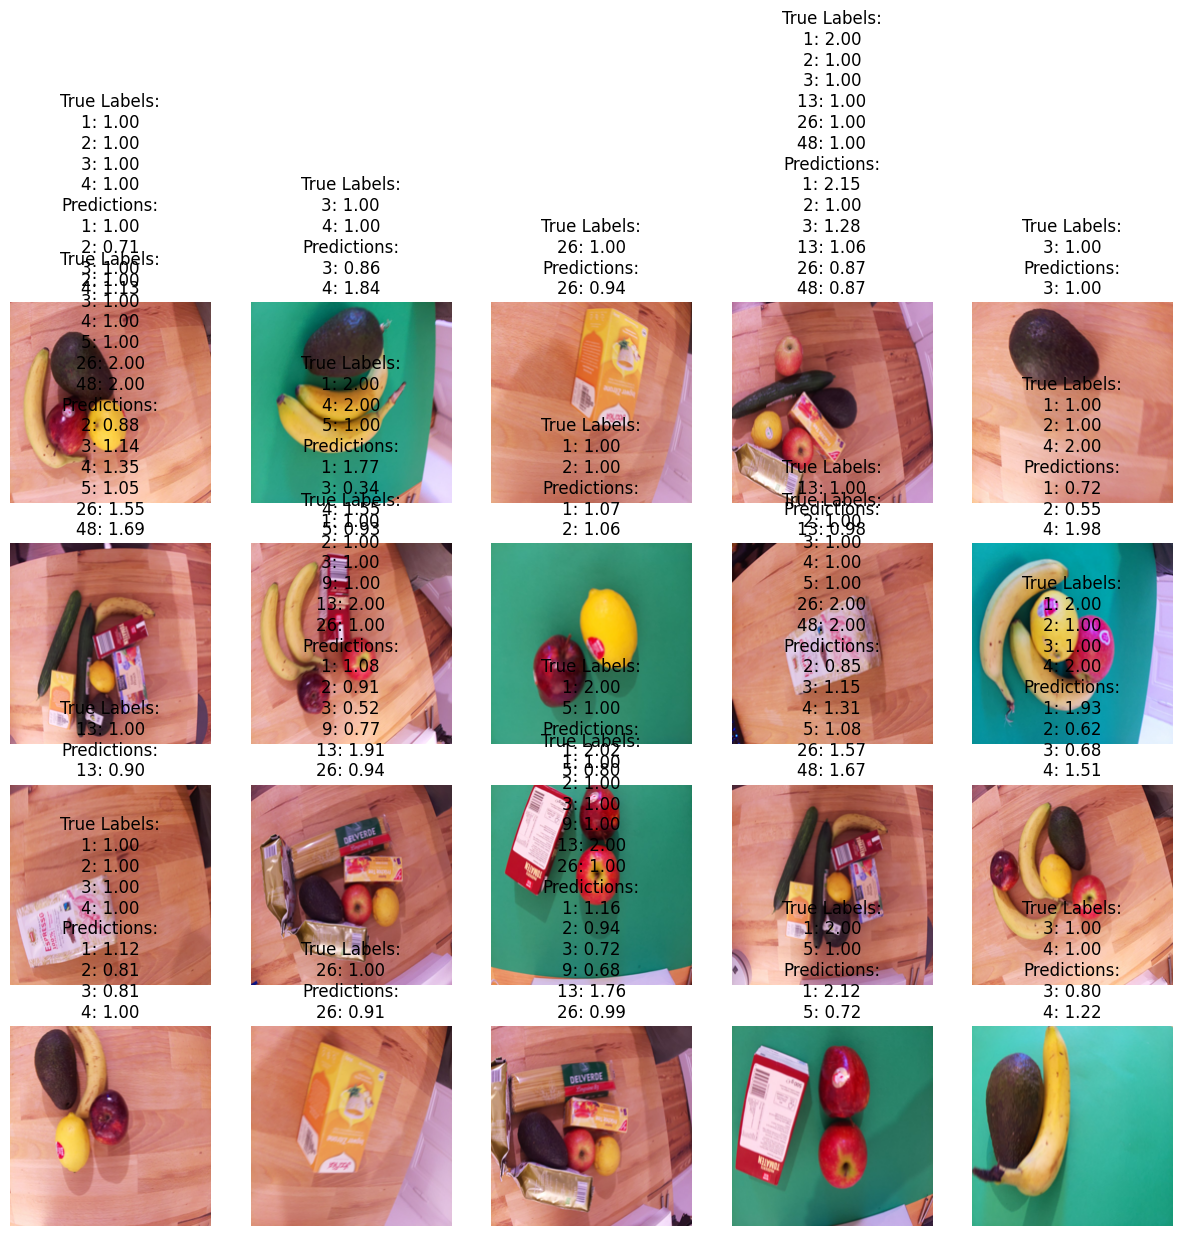

In [28]:
model = TrainModel(getEfficientnetRegression())
model.to(device)
summary(model, input_size=(3, 200, 200))

wandb_logger = configure_wandb(additional_name="_Efficientnet", tags=["Efficientnet"])


checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Track validation loss
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename=wandb_logger.experiment.name,  # Checkpoint file name
    save_top_k=1,  # Save only the best model (lowest val_loss)
    mode='min',  # We are minimizing validation loss
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    mode="min",      
    min_delta=0.03,
    patience=8,          
)


try:
    trainer = pl.Trainer(max_epochs=5, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping], fast_dev_run=False, accelerator=str(device), devices=1)

    trainer.fit(model, train_loader, val_loader) 

    # Load the best model for testing
    trainer.test(model, test_loader, ckpt_path=checkpoint_callback.best_model_path)

    show_predictions(model, test_dataset)
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    wandb.finish()
